# HMM Activity Recognition

This notebook implements a complete pipeline for human activity recognition using Hidden Markov Models:
1. Data loading and preprocessing
2. Feature extraction (time and frequency domain)
3. HMM training with Baum-Welch algorithm
4. Activity decoding with Viterbi algorithm
5. Evaluation on unseen data
6. Performance metrics (sensitivity, specificity, accuracy)


In [256]:
import pandas as pd
import numpy as np
import os
import glob
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(42)


In [257]:
def load_and_clean_data(data_dir='dataset'):
    """
    Load sensor data from CSV files and perform basic cleaning.
    """
    sensor_data = defaultdict(list)

    # Canonical activity names
    valid_activities = {"holding", "jumping", "running", "shaking", "still", "walking"}
    
    # Get all activity folders
    activity_folders = glob.glob(os.path.join(data_dir, '*'))
    activity_folders = [f for f in activity_folders if os.path.isdir(f)]
    
    for folder in sorted(activity_folders):
        folder_name = os.path.basename(folder)
        
        # Extract and normalize activity name (handles case and duplicates like "Running" vs "running")
        raw_name = ''.join([i for i in folder_name if not i.isdigit()]).split('-')[0]
        activity_name = raw_name.strip().lower()
        if activity_name not in valid_activities:
            # Skip folders that are not one of the target activities
            continue
        
        # Load accelerometer data
        accel_file = os.path.join(folder, 'Accelerometer.csv')
        gyro_file = os.path.join(folder, 'Gyroscope.csv')
        
        if os.path.exists(accel_file) and os.path.exists(gyro_file):
            try:
                # Load sensors
                accel_df = pd.read_csv(accel_file)
                gyro_df = pd.read_csv(gyro_file)
                
                # Remove time column, keep seconds_elapsed
                accel_df = accel_df.drop('time', axis=1) if 'time' in accel_df.columns else accel_df
                gyro_df = gyro_df.drop('time', axis=1) if 'time' in gyro_df.columns else gyro_df
                
                # Merge accelerometer and gyroscope data
                merged_df = accel_df.merge(gyro_df, on=['seconds_elapsed'], suffixes=('_accel', '_gyro'))
                
                # Rename columns for clarity
                merged_df = merged_df.rename(columns={
                    'x_accel': 'accel_x', 'y_accel': 'accel_y', 'z_accel': 'accel_z',
                    'x_gyro': 'gyro_x', 'y_gyro': 'gyro_y', 'z_gyro': 'gyro_z'
                })
                
                # Add metadata
                merged_df['activity'] = activity_name
                merged_df['trial'] = folder_name
                merged_df['sequence_id'] = f"{activity_name}_{len(sensor_data[activity_name])}"
                merged_df['sample_index'] = np.arange(len(merged_df))
                
                # Remove missing values
                merged_df = merged_df.dropna()
                
                sensor_data[activity_name].append(merged_df)
                print(f"Loaded and cleaned: {folder_name}")
                
            except Exception as e:
                print(f"Error loading {folder_name}: {e}")
    
    # Combine all data
    all_data = []
    for activity, dataframes in sensor_data.items():
        all_data.extend(dataframes)
    
    combined_df = pd.concat(all_data, ignore_index=True)
    return combined_df, sensor_data


In [258]:
# Load and clean the data
print("Loading and cleaning data...")
cleaned_df, sensor_dict = load_and_clean_data('dataset')

print(f"\nTotal samples: {len(cleaned_df)}")
print(f"\nActivities found: {sorted(cleaned_df['activity'].unique())}")
print(f"\nColumns: {cleaned_df.columns.tolist()}")


Loading and cleaning data...
Loaded and cleaned: Running11-2025-10-30_09-54-41
Loaded and cleaned: Running12-2025-10-30_09-55-08
Loaded and cleaned: Shaking11-2025-10-30_09-52-59
Loaded and cleaned: Shaking12-2025-10-30_09-53-26
Loaded and cleaned: Still12-2025-10-30_09-52-10
Loaded and cleaned: Walking11-2025-10-30_09-51-30
Loaded and cleaned: Walking12-2025-10-30_09-53-56
Loaded and cleaned: holding1-2025-10-23_15-10-03
Loaded and cleaned: holding10-2025-10-30_15-32-56
Loaded and cleaned: holding2-2025-10-25_09-36-20
Loaded and cleaned: holding3-2025-10-25_09-36-31
Loaded and cleaned: holding4-2025-10-25_09-36-43
Loaded and cleaned: holding5-2025-10-25_09-37-01
Loaded and cleaned: holding6-2025-10-30_15-33-51
Loaded and cleaned: holding7-2025-10-30_15-33-38
Loaded and cleaned: holding8-2025-10-30_15-33-20
Loaded and cleaned: holding9-2025-10-30_15-33-08
Loaded and cleaned: jumping1-2025-10-23_15-07-37
Loaded and cleaned: jumping10-2025-10-30_15-38-35
Loaded and cleaned: jumping2-2025

In [259]:
# Organize data by activity
organized_data = {}
for activity in cleaned_df['activity'].unique():
    organized_data[activity] = cleaned_df[cleaned_df['activity'] == activity]
    print(f"{activity}: {len(organized_data[activity])} samples")

print(f"\nData is now organized by activity. Access using organized_data['activity_name']")


running: 12392 samples
shaking: 11849 samples
still: 13693 samples
walking: 12689 samples
holding: 9995 samples
jumping: 9834 samples

Data is now organized by activity. Access using organized_data['activity_name']


## 5. Visualize Cleaned Data


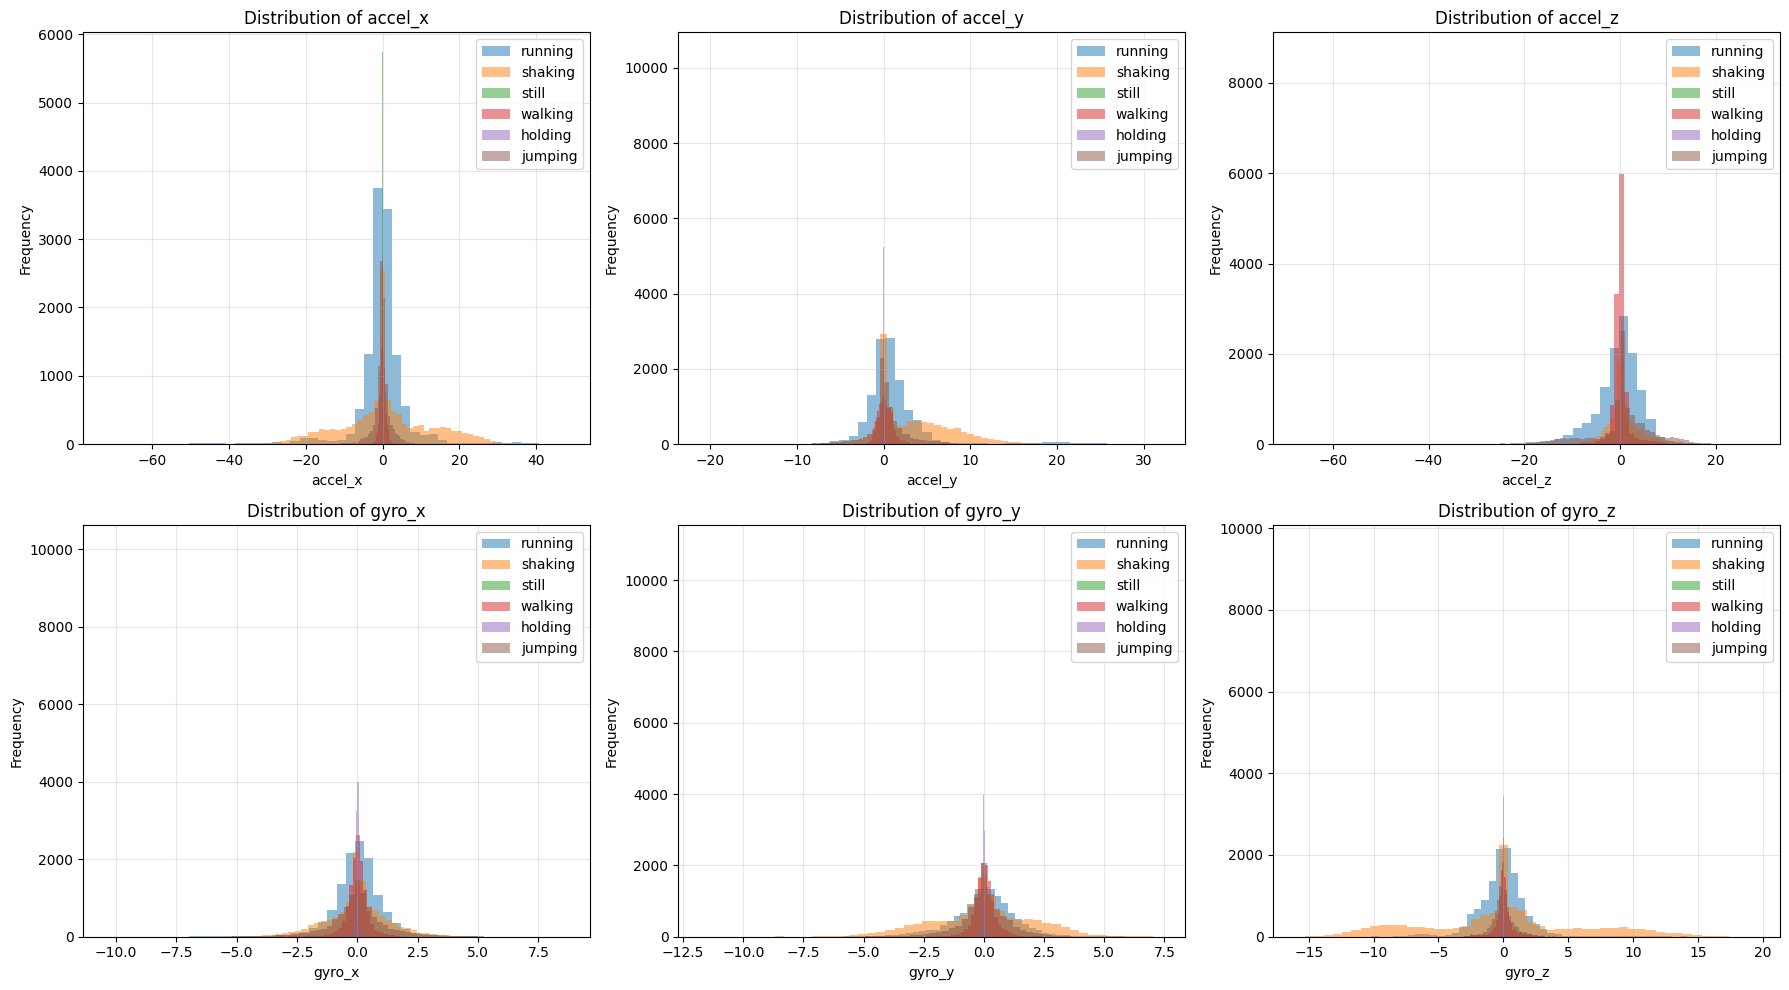


Visualization of cleaned data complete.


In [260]:
# Visualize sensor readings by activity
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

sensor_cols = ['accel_x', 'accel_y', 'accel_z', 'gyro_x', 'gyro_y', 'gyro_z']

for idx, col in enumerate(sensor_cols):
    ax = axes[idx]
    
    for activity in cleaned_df['activity'].unique():
        activity_data = cleaned_df[cleaned_df['activity'] == activity][col]
        ax.hist(activity_data, bins=50, alpha=0.5, label=activity)
    
    ax.set_title(f'Distribution of {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Frequency')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nVisualization of cleaned data complete.")


## 6. Extract Features for HMM


In [261]:
from scipy import stats
from scipy.fft import fft, fftfreq
from scipy.signal import butter, filtfilt, welch

def extract_time_domain_features(window_data):
    """Extract enhanced time-domain features with activity-specific discriminators."""
    features = {}
    
    # Sensor columns
    sensor_cols = ['accel_x', 'accel_y', 'accel_z', 'gyro_x', 'gyro_y', 'gyro_z']
    
    for col in sensor_cols:
        if col in window_data.columns:
            signal = window_data[col].values
            
            # Basic statistical features
            features[f'{col}_mean'] = window_data[col].mean()
            features[f'{col}_variance'] = window_data[col].var()
            features[f'{col}_std'] = window_data[col].std()
            features[f'{col}_sma'] = window_data[col].abs().sum()
            
            # Extended statistical features
            features[f'{col}_median'] = window_data[col].median()
            features[f'{col}_min'] = window_data[col].min()
            features[f'{col}_max'] = window_data[col].max()
            features[f'{col}_range'] = window_data[col].max() - window_data[col].min()
            
            # Distribution shape features
            features[f'{col}_skewness'] = stats.skew(signal)
            features[f'{col}_kurtosis'] = stats.kurtosis(signal)
            
            # Energy
            features[f'{col}_energy'] = np.sum(signal**2)
            
            # Zero crossing rate
            features[f'{col}_zcr'] = np.sum(np.diff(np.signbit(signal))) / (len(signal) - 1)
            
            # Percentiles for better distribution understanding
            features[f'{col}_percentile_25'] = np.percentile(signal, 25)
            features[f'{col}_percentile_75'] = np.percentile(signal, 75)
            features[f'{col}_iqr'] = np.percentile(signal, 75) - np.percentile(signal, 25)
    
    # Correlation between axes
    if 'accel_x' in window_data.columns and 'accel_y' in window_data.columns:
        features['accel_corr_xy'] = window_data['accel_x'].corr(window_data['accel_y'])
    if 'accel_x' in window_data.columns and 'accel_z' in window_data.columns:
        features['accel_corr_xz'] = window_data['accel_x'].corr(window_data['accel_z'])
    if 'accel_y' in window_data.columns and 'accel_z' in window_data.columns:
        features['accel_corr_yz'] = window_data['accel_y'].corr(window_data['accel_z'])
    
    if 'gyro_x' in window_data.columns and 'gyro_y' in window_data.columns:
        features['gyro_corr_xy'] = window_data['gyro_x'].corr(window_data['gyro_y'])
    if 'gyro_x' in window_data.columns and 'gyro_z' in window_data.columns:
        features['gyro_corr_xz'] = window_data['gyro_x'].corr(window_data['gyro_z'])
    if 'gyro_y' in window_data.columns and 'gyro_z' in window_data.columns:
        features['gyro_corr_yz'] = window_data['gyro_y'].corr(window_data['gyro_z'])
    
    # Acceleration magnitude - key for distinguishing static activities
    if 'accel_x' in window_data.columns and 'accel_y' in window_data.columns and 'accel_z' in window_data.columns:
        accel_mag = np.sqrt(window_data['accel_x']**2 + window_data['accel_y']**2 + window_data['accel_z']**2)
        features['accel_mag_mean'] = accel_mag.mean()
        features['accel_mag_std'] = accel_mag.std()
        features['accel_mag_max'] = accel_mag.max()
        features['accel_mag_min'] = accel_mag.min()
        features['accel_mag_median'] = accel_mag.median()
        features['accel_mag_variance'] = accel_mag.var()
        
        # Jerk (change in acceleration)
        jerk = np.diff(accel_mag.values)
        features['accel_mag_jerk_mean'] = jerk.mean() if len(jerk) > 0 else 0
        features['accel_mag_jerk_std'] = jerk.std() if len(jerk) > 0 else 0
    
    # Gyroscope magnitude
    if 'gyro_x' in window_data.columns and 'gyro_y' in window_data.columns and 'gyro_z' in window_data.columns:
        gyro_mag = np.sqrt(window_data['gyro_x']**2 + window_data['gyro_y']**2 + window_data['gyro_z']**2)
        features['gyro_mag_mean'] = gyro_mag.mean()
        features['gyro_mag_std'] = gyro_mag.std()
        features['gyro_mag_max'] = gyro_mag.max()
        features['gyro_mag_min'] = gyro_mag.min()
        features['gyro_mag_median'] = gyro_mag.median()
        features['gyro_mag_variance'] = gyro_mag.var()
        
        # Angular jerk
        angular_jerk = np.diff(gyro_mag.values)
        features['gyro_mag_jerk_mean'] = angular_jerk.mean() if len(angular_jerk) > 0 else 0
        features['gyro_mag_jerk_std'] = angular_jerk.std() if len(angular_jerk) > 0 else 0
    
    return features

def extract_frequency_domain_features(window_data, sampling_rate=100):
    """Extract enhanced frequency-domain features with activity-specific discriminators."""
    features = {}
    
    # Sensor columns
    sensor_cols = ['accel_x', 'accel_y', 'accel_z', 'gyro_x', 'gyro_y', 'gyro_z']
    
    for col in sensor_cols:
        if col in window_data.columns:
            signal = window_data[col].values
            
            # Compute FFT
            fft_vals = fft(signal)
            fft_freq = fftfreq(len(signal), 1/sampling_rate)
            
            # Dominant frequency
            magnitude = np.abs(fft_vals)
            dominant_freq_idx = np.argmax(magnitude[1:len(magnitude)//2]) + 1
            features[f'{col}_dominant_freq'] = np.abs(fft_freq[dominant_freq_idx])
            
            # Spectral energy
            features[f'{col}_spectral_energy'] = np.sum(magnitude**2)
            
            # FFT components
            features[f'{col}_fft_component_1'] = magnitude[1] if len(magnitude) > 1 else 0
            features[f'{col}_fft_component_2'] = magnitude[2] if len(magnitude) > 2 else 0
            features[f'{col}_fft_component_3'] = magnitude[3] if len(magnitude) > 3 else 0
            
            # Spectral entropy
            if np.sum(magnitude) > 0:
                magnitude_norm = magnitude / np.sum(magnitude)
                spectral_entropy = -np.sum(magnitude_norm * np.log2(magnitude_norm + 1e-10))
                features[f'{col}_spectral_entropy'] = spectral_entropy
            else:
                features[f'{col}_spectral_entropy'] = 0
            
            # Mean frequency
            mean_freq = np.sum(fft_freq * magnitude) / np.sum(magnitude) if np.sum(magnitude) > 0 else 0
            features[f'{col}_mean_freq'] = mean_freq
    
    # Combined magnitude FFT and band-power features
    if 'accel_x' in window_data.columns and 'accel_y' in window_data.columns and 'accel_z' in window_data.columns:
        accel_mag = np.sqrt(window_data['accel_x']**2 + window_data['accel_y']**2 + window_data['accel_z']**2)
        accel_mag_values = accel_mag.values
        
        # Dominant frequency on magnitude
        fft_vals = fft(accel_mag_values)
        magnitude = np.abs(fft_vals)
        dominant_freq_idx = np.argmax(magnitude[1:len(magnitude)//2]) + 1
        fft_freq = fftfreq(len(accel_mag_values), 1/sampling_rate)
        features['accel_mag_dominant_freq'] = np.abs(fft_freq[dominant_freq_idx])
        features['accel_mag_spectral_energy'] = np.sum(magnitude**2)
        
        # Band powers using Welch (helps separate walking vs running)
        freqs, psd = welch(accel_mag_values, fs=sampling_rate, nperseg=min(256, len(accel_mag_values)))
        def band_power(f_lo, f_hi):
            mask = (freqs >= f_lo) & (freqs <= f_hi)
            return np.trapz(psd[mask], freqs[mask]) if np.any(mask) else 0.0
        power_walk = band_power(0.8, 3.0)
        power_run = band_power(2.5, 5.0)
        total_power = np.trapz(psd, freqs)
        features['accel_mag_power_walk_band'] = power_walk
        features['accel_mag_power_run_band'] = power_run
        features['accel_mag_power_ratio_run_walk'] = (power_run / (power_walk + 1e-8))
        features['accel_mag_power_frac'] = (power_walk + power_run) / (total_power + 1e-8)
        
        # Step rate proxy (peak in 0.8–3 Hz)
        mask_walk = (freqs >= 0.8) & (freqs <= 3.0)
        if np.any(mask_walk):
            idx = np.argmax(psd[mask_walk])
            features['step_rate_hz'] = freqs[mask_walk][idx]
        else:
            features['step_rate_hz'] = 0.0
        
        # High-pass accel magnitude (~0.3 Hz) via simple Butterworth
        try:
            b, a = butter(2, 0.3 / (0.5 * sampling_rate), btype='high')
            hp = filtfilt(b, a, accel_mag_values)
            features['accel_mag_hp_std'] = np.std(hp)
            features['accel_mag_hp_energy'] = np.sum(hp**2)
        except Exception:
            features['accel_mag_hp_std'] = 0.0
            features['accel_mag_hp_energy'] = 0.0
    
    return features

def extract_features_from_sequence(sequence_data, window_size=200, overlap=0.5):
    """
    Extract features from a sequence using sliding windows.
    
    Parameters:
    -----------
    sequence_data : pd.DataFrame
        Sensor data for a single sequence
    window_size : int
        Size of each window (number of samples)
    overlap : float
        Overlap ratio (0-1)
    
    Returns:
    --------
    pd.DataFrame : Feature matrix with extracted features
    """
    features_list = []
    step_size = int(window_size * (1 - overlap))
    
    for i in range(0, len(sequence_data) - window_size + 1, step_size):
        window = sequence_data.iloc[i:i+window_size]
        
        # Extract features
        time_features = extract_time_domain_features(window)
        freq_features = extract_frequency_domain_features(window)
        
        # Combine features
        all_features = {**time_features, **freq_features}
        all_features['window_start'] = i
        all_features['window_end'] = i + window_size
        
        features_list.append(all_features)
    
    return pd.DataFrame(features_list)


In [262]:
# Extract features from all sequences
print("Extracting features from cleaned data...")
all_features = []

for seq_id in cleaned_df['sequence_id'].unique():
    sequence_data = cleaned_df[cleaned_df['sequence_id'] == seq_id].reset_index(drop=True)
    activity = sequence_data['activity'].iloc[0]
    
    # Extract features (2.0s window to improve class separability for dynamics)
    feature_df = extract_features_from_sequence(
        sequence_data,
        window_size=200,  # 200 samples = 2.0 seconds at 100Hz
        overlap=0.75  # 75% overlap for denser windows
    )
    
    # Add metadata
    feature_df['activity'] = activity
    feature_df['sequence_id'] = seq_id
    
    all_features.append(feature_df)
    print(f"Extracted features from {seq_id}: {len(feature_df)} windows")

# Combine all features
feature_matrix = pd.concat(all_features, ignore_index=True)

print(f"\nTotal feature windows extracted: {len(feature_matrix)}")
print(f"Number of features per window: {len(feature_matrix.columns) - 3}")  # minus metadata columns


Extracting features from cleaned data...
Extracted features from running_0: 18 windows
Extracted features from running_1: 20 windows
Extracted features from running_2: 15 windows
Extracted features from running_3: 17 windows
Extracted features from running_4: 16 windows
Extracted features from running_5: 16 windows
Extracted features from running_6: 19 windows
Extracted features from running_7: 18 windows
Extracted features from running_8: 16 windows
Extracted features from running_9: 18 windows
Extracted features from running_10: 17 windows
Extracted features from running_11: 16 windows
Extracted features from shaking_0: 19 windows
Extracted features from shaking_1: 23 windows
Extracted features from shaking_2: 9 windows
Extracted features from shaking_3: 16 windows
Extracted features from shaking_4: 15 windows
Extracted features from shaking_5: 15 windows
Extracted features from shaking_6: 13 windows
Extracted features from shaking_7: 18 windows
Extracted features from shaking_8: 16 

In [263]:
# Display feature information
print("\nFeature Matrix Summary:")
print(f"Shape: {feature_matrix.shape}")
print(f"\nFeatures: {[col for col in feature_matrix.columns if col not in ['activity', 'sequence_id', 'window_start', 'window_end']]}")

print(f"\nActivities in feature matrix: {sorted(feature_matrix['activity'].unique())}")
print(f"\nFeature matrix head:")
print(feature_matrix.head())



Feature Matrix Summary:
Shape: (1171, 167)

Features: ['accel_x_mean', 'accel_x_variance', 'accel_x_std', 'accel_x_sma', 'accel_x_median', 'accel_x_min', 'accel_x_max', 'accel_x_range', 'accel_x_skewness', 'accel_x_kurtosis', 'accel_x_energy', 'accel_x_zcr', 'accel_x_percentile_25', 'accel_x_percentile_75', 'accel_x_iqr', 'accel_y_mean', 'accel_y_variance', 'accel_y_std', 'accel_y_sma', 'accel_y_median', 'accel_y_min', 'accel_y_max', 'accel_y_range', 'accel_y_skewness', 'accel_y_kurtosis', 'accel_y_energy', 'accel_y_zcr', 'accel_y_percentile_25', 'accel_y_percentile_75', 'accel_y_iqr', 'accel_z_mean', 'accel_z_variance', 'accel_z_std', 'accel_z_sma', 'accel_z_median', 'accel_z_min', 'accel_z_max', 'accel_z_range', 'accel_z_skewness', 'accel_z_kurtosis', 'accel_z_energy', 'accel_z_zcr', 'accel_z_percentile_25', 'accel_z_percentile_75', 'accel_z_iqr', 'gyro_x_mean', 'gyro_x_variance', 'gyro_x_std', 'gyro_x_sma', 'gyro_x_median', 'gyro_x_min', 'gyro_x_max', 'gyro_x_range', 'gyro_x_skewne

## 7. Prepare Observation Sequences for HMM


In [264]:
def prepare_observation_sequences(feature_matrix):
    """
    Organize feature matrix into observation sequences for HMM.
    Each sequence contains all feature windows from one trial.
    """
    observation_sequences = defaultdict(list)
    
    for seq_id in feature_matrix['sequence_id'].unique():
        seq_features = feature_matrix[feature_matrix['sequence_id'] == seq_id]
        activity = seq_features['activity'].iloc[0]
        
        # Get feature values only (exclude metadata columns)
        exclude_cols = ['activity', 'sequence_id', 'window_start', 'window_end']
        feature_cols = [col for col in seq_features.columns if col not in exclude_cols]
        
        observation_seq = seq_features[feature_cols].values
        
        observation_sequences[activity].append({
            'sequence_id': seq_id,
            'observation_sequence': observation_seq,
            'length': len(observation_seq)
        })
    
    return observation_sequences

# Prepare observation sequences
observation_sequences = prepare_observation_sequences(feature_matrix)

print("Observation sequences prepared for HMM:")
for activity in sorted(observation_sequences.keys()):
    seq_lengths = [s['length'] for s in observation_sequences[activity]]
    print(f"{activity}: {len(observation_sequences[activity])} sequences, "
          f"window lengths: min={min(seq_lengths)}, max={max(seq_lengths)}, "
          f"mean={np.mean(seq_lengths):.1f}")


Observation sequences prepared for HMM:
holding: 10 sequences, window lengths: min=15, max=21, mean=16.5
jumping: 10 sequences, window lengths: min=14, max=18, mean=16.3
running: 12 sequences, window lengths: min=15, max=20, mean=17.2
shaking: 12 sequences, window lengths: min=9, max=23, mean=16.1
still: 12 sequences, window lengths: min=16, max=44, mean=19.3
walking: 12 sequences, window lengths: min=15, max=26, mean=17.7


In [265]:
# Save feature matrix and observation sequences for HMM training
import pickle
import os

# Create directories if they don't exist
os.makedirs('features', exist_ok=True)
os.makedirs('models', exist_ok=True)
os.makedirs('results', exist_ok=True)

# Save feature matrix
feature_matrix.to_csv('features/feature_matrix.csv', index=False)
print("Saved: features/feature_matrix.csv")

# Save observation sequences
with open('features/observation_sequences.pkl', 'wb') as f:
    pickle.dump(observation_sequences, f)
print("Saved: features/observation_sequences.pkl")

print("\nFeature extraction complete. Ready for HMM training!")


Saved: features/feature_matrix.csv
Saved: features/observation_sequences.pkl

Feature extraction complete. Ready for HMM training!


## 8. Define HMM Model Components


In [266]:
from hmmlearn import hmm
import pickle
import joblib
import os

# Load observation sequences
with open('features/observation_sequences.pkl', 'rb') as f:
    observation_sequences = pickle.load(f)
    
# Check if model and scaler exist (for retraining after improvements)
model_exists = os.path.exists('models/hmm_activity_model.pkl')
scaler_exists = os.path.exists('models/feature_scaler.pkl')
    
if model_exists and scaler_exists:
    print("⚠️  Previous model found. This cell will retrain with improved parameters.")
    print("    If you want to use the old model, skip ahead to evaluation cells.")

print("HMM Model Components:\n")
print("="*60)

# Define hidden states (activities)
hidden_states = sorted(observation_sequences.keys())
n_states = len(hidden_states)

print(f"Hidden States (Z): {hidden_states}")
print(f"Number of states: {n_states}")

# Count observations
total_sequences = sum(len(sequences) for sequences in observation_sequences.values())
print(f"\nObservations (X): {total_sequences} sequences")

# Get feature dimensions
first_seq = next(iter(observation_sequences.values()))[0]['observation_sequence']
n_features = first_seq.shape[1]
print(f"Feature dimensions: {n_features}")

print(f"\nModel Parameters to Learn:")
print(f"  - Transition Probabilities (A): {n_states}x{n_states} matrix")
print(f"  - Emission Probabilities (B): Gaussian distributions with {n_features} features")
print(f"  - Initial State Probabilities (π): {n_states} vector")


⚠️  Previous model found. This cell will retrain with improved parameters.
    If you want to use the old model, skip ahead to evaluation cells.
HMM Model Components:

Hidden States (Z): ['holding', 'jumping', 'running', 'shaking', 'still', 'walking']
Number of states: 6

Observations (X): 68 sequences
Feature dimensions: 163

Model Parameters to Learn:
  - Transition Probabilities (A): 6x6 matrix
  - Emission Probabilities (B): Gaussian distributions with 163 features
  - Initial State Probabilities (π): 6 vector


## 9. Model Implementation and Training


In [267]:
def prepare_training_data(observation_sequences, activity_labels):
    """
    Prepare observation sequences and state sequences for training.
    
    Returns:
    --------
    X : list of observation arrays (for each sequence)
    lengths : array of sequence lengths
    y : state labels for each sequence
    """
    X_list = []
    lengths = []
    y_list = []
    
    for activity_idx, activity in enumerate(activity_labels):
        for sequence_info in observation_sequences[activity]:
            obs = sequence_info['observation_sequence']
            X_list.append(obs)
            lengths.append(len(obs))
            y_list.extend([activity_idx] * len(obs))
    
    return X_list, lengths, np.array(y_list)

# Prepare training data
activity_labels = sorted(observation_sequences.keys())
X_train, lengths, y_train = prepare_training_data(observation_sequences, activity_labels)

print(f"Training data prepared:")
print(f"  Total sequences: {len(X_train)}")
print(f"  Sequence lengths: min={min(lengths)}, max={max(lengths)}, mean={np.mean(lengths):.1f}")
print(f"  Activities: {activity_labels}")


Training data prepared:
  Total sequences: 68
  Sequence lengths: min=9, max=44, mean=17.2
  Activities: ['holding', 'jumping', 'running', 'shaking', 'still', 'walking']


In [268]:
# Feature scaling and dimensionality reduction for better training
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from hmmlearn.hmm import GMMHMM

print("Scaling features and applying PCA...")
scaler = StandardScaler()

# Flatten and scale features
X_flat = np.vstack(X_train)
X_scaled = scaler.fit_transform(X_flat)

# PCA to a fixed dimensionality to stabilize GMM estimation
pca = PCA(n_components=40, random_state=42)
X_pca = pca.fit_transform(X_scaled)

print(f"Feature preprocessing complete:")
print(f"  Scaled mean: {X_scaled.mean():.2f}, std: {X_scaled.std():.2f}")
print(f"  PCA components: {X_pca.shape[1]}")

# Create and train a stronger, numerically-stable GMM-HMM
print("\nTraining GMM-HMM with tuned parameters...")
model = GMMHMM(
    n_components=n_states,
    n_mix=4,  # four Gaussian mixtures per state
    covariance_type="diag",  # diag is more stable than full at higher dims
    n_iter=800,
    tol=1e-3,
    random_state=42,
    verbose=True
)

# Train the model (Baum-Welch)
model.fit(X_pca, lengths=lengths)

print("\nTraining complete!")
print(f"Final log likelihood: {model.score(X_pca, lengths=lengths):.2f}")


Scaling features and applying PCA...
Feature preprocessing complete:
  Scaled mean: 0.00, std: 1.00
  PCA components: 40

Training GMM-HMM with tuned parameters...


         1  -70526.70302611             +nan
         2  -54698.75525445  +15827.94777166
         3  -52120.02295696   +2578.73229749
         4  -51392.58656887    +727.43638809
         5  -51142.92478706    +249.66178181
         6  -50969.96647283    +172.95831423
         7  -50831.07764686    +138.88882597
         8  -50757.01311892     +74.06452794
         9  -50723.69885559     +33.31426333
        10  -50691.09709024     +32.60176535
        11  -50654.60633672     +36.49075353
        12  -50638.06363076     +16.54270596
        13  -50610.00555778     +28.05807298
        14  -50577.53669143     +32.46886635
        15  -50526.03838428     +51.49830715
        16  -50502.86415330     +23.17423097
        17  -50499.80097352      +3.06317978
        18  -50497.46232120      +2.33865232
        19  -50494.12969315      +3.33262805
        20  -50472.60886498     +21.52082817
        21  -50457.23860972     +15.37025526
        22  -50437.06570652     +20.17290319
        23


Training complete!
Final log likelihood: -50428.16


        46  -50428.16494799      +0.00032452


In [269]:
# Train per-class HMMs (one model per activity) for sequence-level classification
from collections import defaultdict
from hmmlearn.hmm import GMMHMM

print("\nTraining per-class GMM-HMMs for sequence-level classification...")
per_class_models = {}

for activity in activity_labels:
    # Collect all sequences for this activity
    seqs = [s['observation_sequence'] for s in observation_sequences[activity]]
    lengths_act = [len(s) for s in seqs]
    X_act = np.vstack(seqs)
    
    # Scale and project using global scaler/PCA
    X_act_scaled = scaler.transform(X_act)
    X_act_pca = pca.transform(X_act_scaled)
    
    # Train a compact model per class
    cls_model = GMMHMM(
        n_components=3,        # smaller number of states per activity
        n_mix=3,               # mixtures per state
        covariance_type="diag",
        n_iter=800,
        tol=1e-3,
        random_state=42,
        verbose=False
    )
    cls_model.fit(X_act_pca, lengths=lengths_act)
    per_class_models[activity] = cls_model
    print(f"  Trained per-class model for {activity}: states=3, mixes=3")

print("Per-class models ready.")



Training per-class GMM-HMMs for sequence-level classification...
  Trained per-class model for holding: states=3, mixes=3
  Trained per-class model for jumping: states=3, mixes=3
  Trained per-class model for running: states=3, mixes=3
  Trained per-class model for shaking: states=3, mixes=3
  Trained per-class model for still: states=3, mixes=3
  Trained per-class model for walking: states=3, mixes=3
Per-class models ready.


In [270]:
# Fast path: skip heavy grid search and use a strong, stable default
print("\nSkipping grid search to speed up execution. Using fixed configuration.")

best_cfg = {"pca": 40, "n_mix": 4, "covariance": "diag"}
print("Best config (fixed):", best_cfg)



Skipping grid search to speed up execution. Using fixed configuration.
Best config (fixed): {'pca': 40, 'n_mix': 4, 'covariance': 'diag'}



Visualizing emission means for the global GMM-HMM (PCA space)...


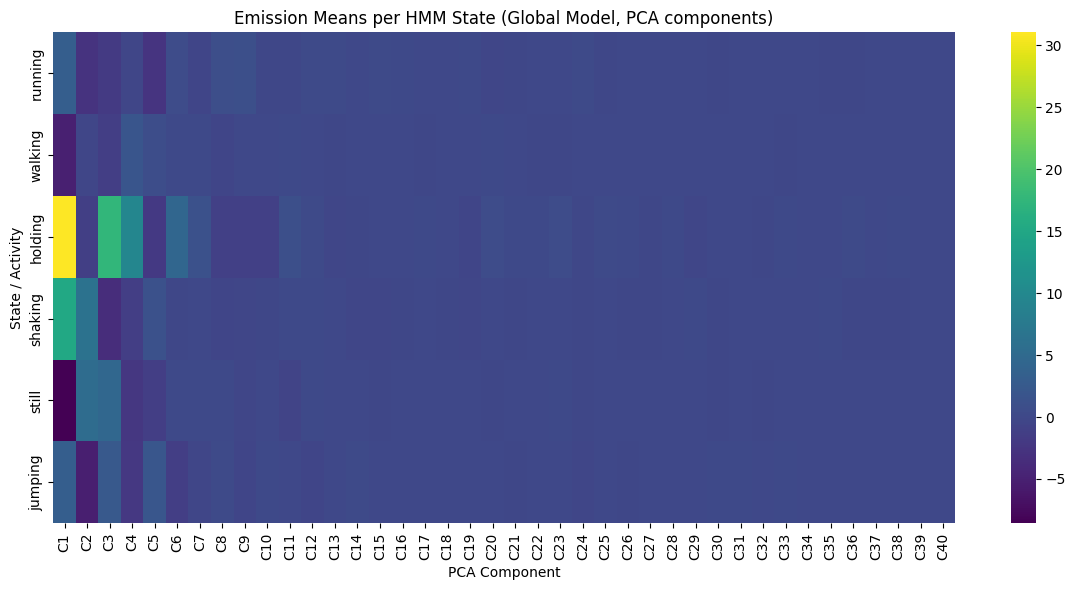

In [271]:
# Visualize Emission Probabilities (state means in PCA space)
print("\nVisualizing emission means for the global GMM-HMM (PCA space)...")
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

if hasattr(model, 'means_'):
    raw_means = model.means_
    # hmmlearn.GMMHMM means_ can be (n_components, n_mix, n_features)
    if raw_means.ndim == 3:
        weights = getattr(model, 'weights_', None)
        if weights is not None and np.isfinite(weights).all():
            means_2d = np.sum(weights[:, :, np.newaxis] * raw_means, axis=1)
        else:
            means_2d = np.mean(raw_means, axis=1)
    else:
        means_2d = raw_means

    # Build safe y-tick labels
    try:
        if 'state_to_activity_map' in globals() and isinstance(state_to_activity_map, dict):
            ytick = []
            for i in range(means_2d.shape[0]):
                mapped = state_to_activity_map.get(i, None)
                if mapped is not None and mapped < len(activity_labels):
                    ytick.append(activity_labels[mapped])
                else:
                    ytick.append(f"State {i}")
        else:
            ytick = [f"State {i}" for i in range(means_2d.shape[0])]
    except Exception:
        ytick = [f"State {i}" for i in range(means_2d.shape[0])]

    plt.figure(figsize=(12, 6))
    sns.heatmap(means_2d, cmap='viridis', cbar=True,
                xticklabels=[f'C{i+1}' for i in range(means_2d.shape[1])],
                yticklabels=ytick)
    plt.title('Emission Means per HMM State (Global Model, PCA components)')
    plt.xlabel('PCA Component')
    plt.ylabel('State / Activity')
    plt.tight_layout()
    plt.show()
else:
    print("Model does not expose means_. Skipping emission visualization.")


## 10. Visualization: Transition Matrix


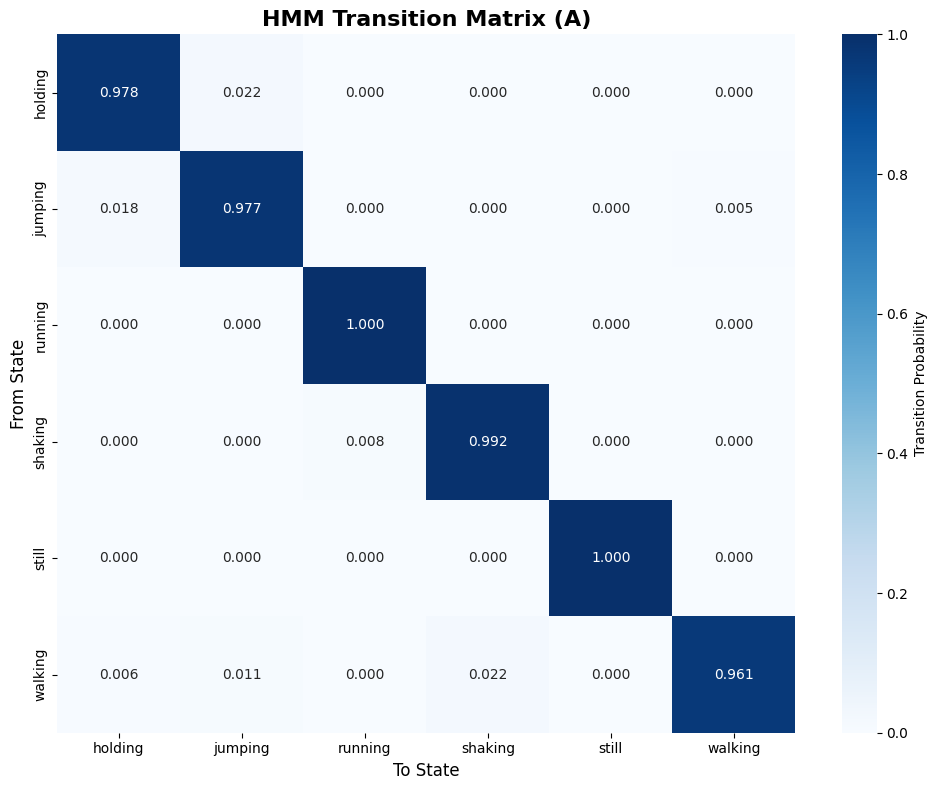

Transition probabilities:
Rows sum to: [1. 1. 1. 1. 1. 1.]


In [272]:
# Display transition matrix as heatmap
import seaborn as sns

plt.figure(figsize=(10, 8))

# Get transition matrix
transition_matrix = model.transmat_

# Create heatmap
sns.heatmap(
    transition_matrix,
    annot=True,
    fmt='.3f',
    cmap='Blues',
    xticklabels=activity_labels,
    yticklabels=activity_labels,
    cbar_kws={'label': 'Transition Probability'}
)

plt.title('HMM Transition Matrix (A)', fontsize=16, fontweight='bold')
plt.xlabel('To State', fontsize=12)
plt.ylabel('From State', fontsize=12)
plt.tight_layout()
plt.show()

print("Transition probabilities:")
print(f"Rows sum to: {transition_matrix.sum(axis=1)}")


## 11. Decode Sequences using Viterbi Algorithm


In [273]:
def decode_sequences(model, observation_sequences, activity_labels, scaler, pca):
    """
    Use Viterbi algorithm to decode the most likely sequence of activities.
    """
    decoded_results = []
    
    for activity_idx, activity in enumerate(activity_labels):
        for seq_info in observation_sequences[activity]:
            obs = seq_info['observation_sequence']
            
            # Scale and project observations
            obs_scaled = scaler.transform(obs)
            obs_pca = pca.transform(obs_scaled)
            
            # Decode using Viterbi algorithm
            decoded_states = model.predict(obs_pca)
            
            decoded_results.append({
                'sequence_id': seq_info['sequence_id'],
                'true_activity': activity,
                'true_activity_idx': activity_idx,
                'decoded_states': decoded_states,
                'observations': obs,
                'length': len(obs)
            })
    
    return decoded_results

# Decode all sequences
print("Decoding sequences with Viterbi algorithm...")
decoded_results = decode_sequences(model, observation_sequences, activity_labels, scaler, pca)
print(f"Decoded {len(decoded_results)} sequences")


Decoding sequences with Viterbi algorithm...
Decoded 68 sequences


In [274]:
# Map HMM states to activities by finding the best alignment
print("\nMapping HMM states to activities based on predictions...")
print("="*60)

# Create state-to-activity mapping based on training data
from scipy.optimize import linear_sum_assignment

state_activity_counts = np.zeros((n_states, n_states))

for activity_idx, activity in enumerate(activity_labels):
    activity_results = [r for r in decoded_results if r['true_activity'] == activity]
    for result in activity_results:
        for predicted_state in result['decoded_states']:
            state_activity_counts[predicted_state, activity_idx] += 1

# Find best mapping: which HMM state corresponds to which activity
cost_matrix = -state_activity_counts  # Negative because we want to maximize
row_indices, col_indices = linear_sum_assignment(cost_matrix)

state_to_activity_map = {row: col for row, col in zip(row_indices, col_indices)}
activity_to_state_map = {col: row for row, col in zip(row_indices, col_indices)}

print("\nState-to-Activity Mapping:")
for state_idx, activity_idx in state_to_activity_map.items():
    print(f"  HMM State {state_idx} -> {activity_labels[activity_idx]}")

print("\n" + "="*60)
print("VITERBI ALGORITHM - DECODING ACCURACY (Training Data)")
print("="*80)

total_correct = 0
total_windows = 0

for activity_idx, activity in enumerate(activity_labels):
    activity_results = [r for r in decoded_results if r['true_activity'] == activity]
    
    # Map the predicted state to the correct activity using our mapping
    correct = 0
    total = 0
    for result in activity_results:
        # Relabel: map predicted HMM state to activity
        predicted_activities = [activity_labels[state_to_activity_map[s]] for s in result['decoded_states']]
        predicted_indices = [activity_labels.index(a) for a in predicted_activities]
        correct += np.sum(np.array(predicted_indices) == activity_idx)
        total += result['length']
    
    accuracy = (correct / total * 100) if total > 0 else 0
    total_correct += correct
    total_windows += total
    
    print(f"\n{activity}:")
    print(f"  Sequences: {len(activity_results)}")
    print(f"  Windows: {total}")
    print(f"  Correctly decoded: {correct}")
    print(f"  Accuracy: {accuracy:.1f}%")

# Overall Viterbi accuracy
overall_viterbi_accuracy = (total_correct / total_windows * 100) if total_windows > 0 else 0
print("\n" + "-"*80)
print(f"OVERALL VITERBI ACCURACY: {overall_viterbi_accuracy:.1f}% ({total_correct}/{total_windows})")
print("="*80)



Mapping HMM states to activities based on predictions...

State-to-Activity Mapping:
  HMM State 0 -> running
  HMM State 1 -> walking
  HMM State 2 -> holding
  HMM State 3 -> shaking
  HMM State 4 -> still
  HMM State 5 -> jumping

VITERBI ALGORITHM - DECODING ACCURACY (Training Data)

holding:
  Sequences: 10
  Windows: 165
  Correctly decoded: 0
  Accuracy: 0.0%

jumping:
  Sequences: 10
  Windows: 163
  Correctly decoded: 157
  Accuracy: 96.3%

running:
  Sequences: 12
  Windows: 206
  Correctly decoded: 158
  Accuracy: 76.7%

shaking:
  Sequences: 12
  Windows: 193
  Correctly decoded: 131
  Accuracy: 67.9%

still:
  Sequences: 12
  Windows: 232
  Correctly decoded: 168
  Accuracy: 72.4%

walking:
  Sequences: 12
  Windows: 212
  Correctly decoded: 169
  Accuracy: 79.7%

--------------------------------------------------------------------------------
OVERALL VITERBI ACCURACY: 66.9% (783/1171)


## 12. Visualize Decoded Sequences


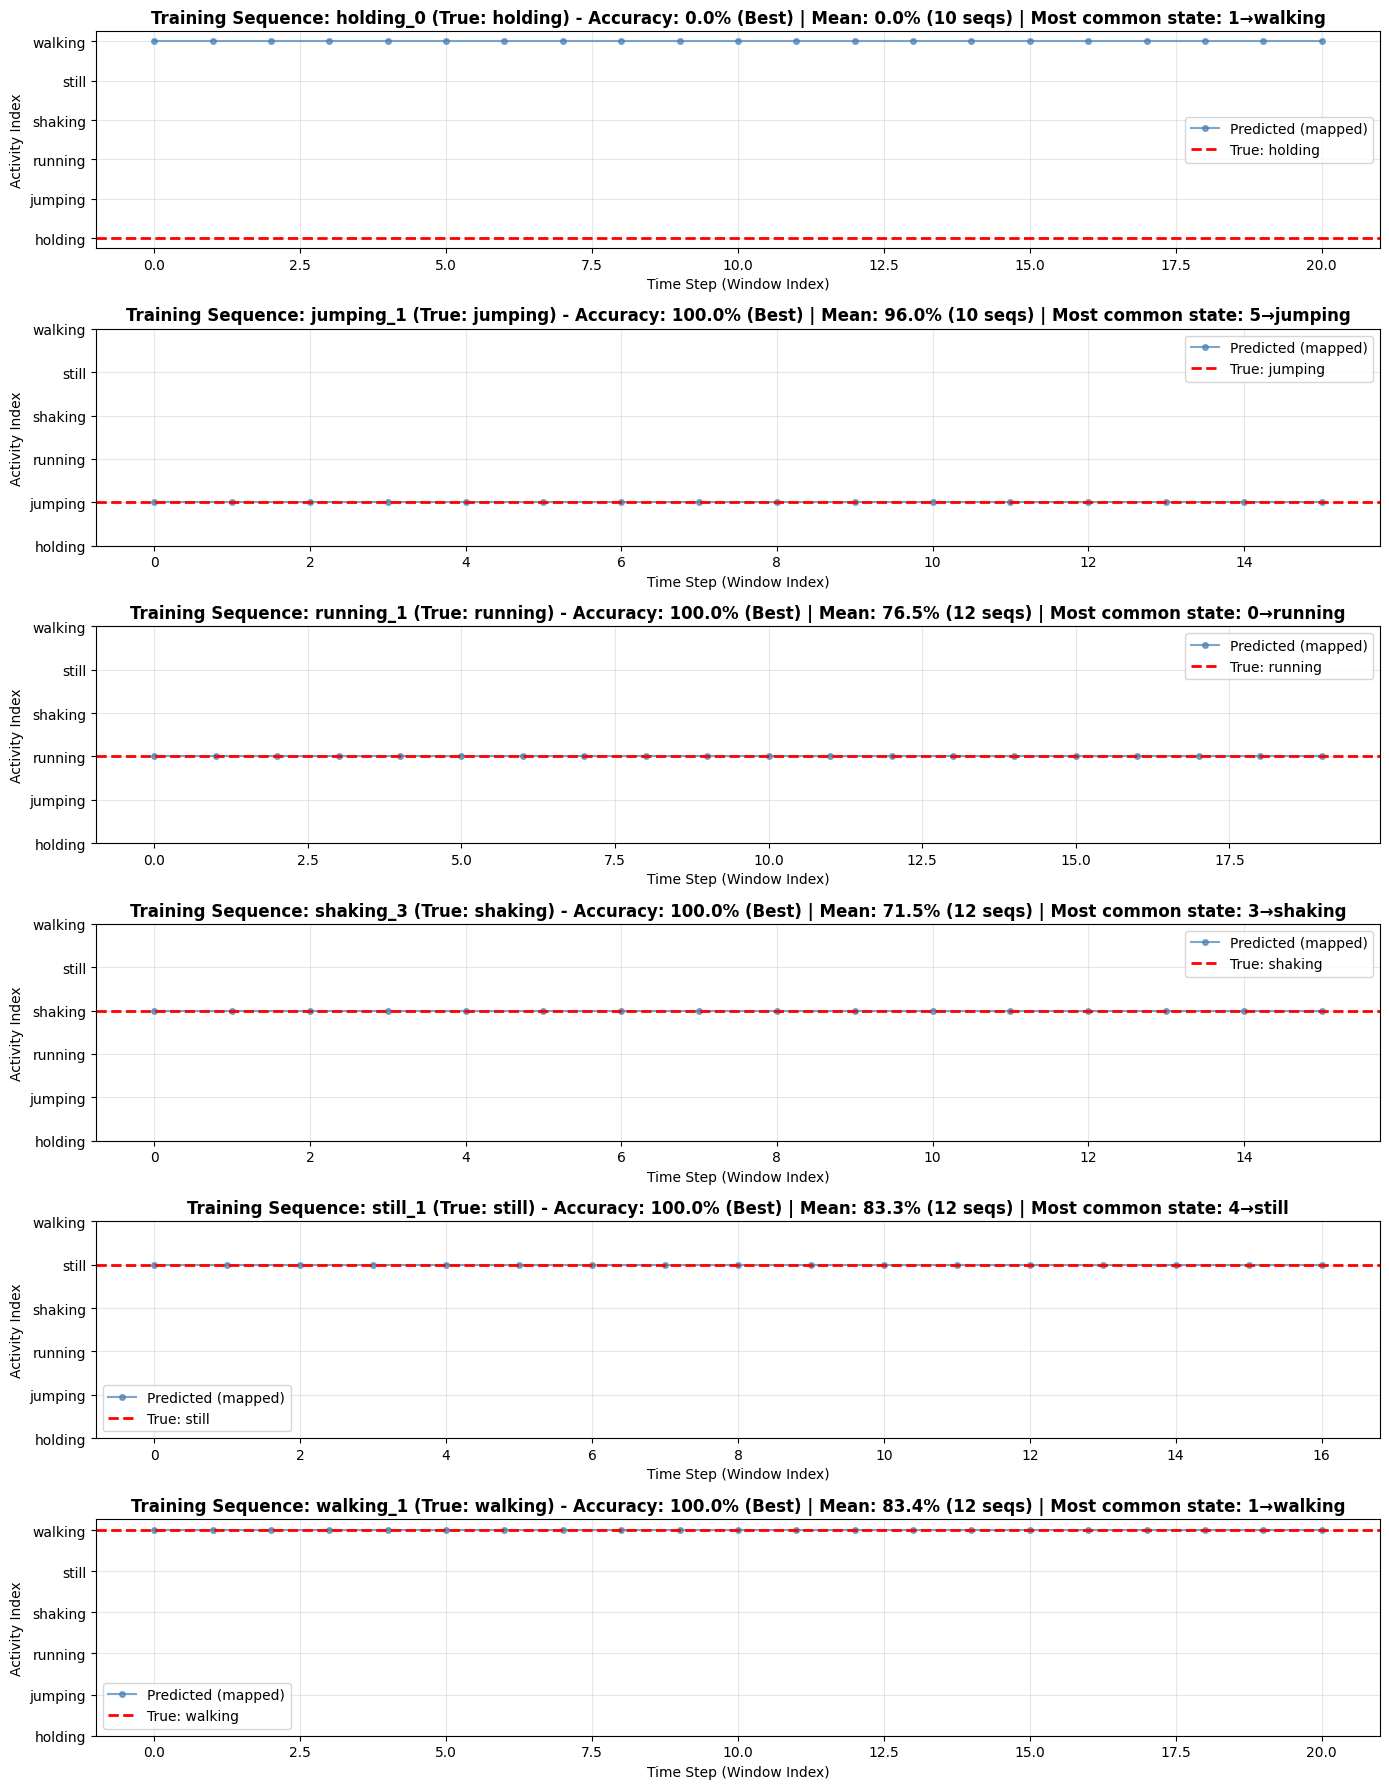

In [275]:
# Plot decoded sequences for each activity (Training Data)
# Map raw HMM states to activity indices for interpretable visualization

# Ensure state_to_activity_map exists
if 'state_to_activity_map' not in globals() or state_to_activity_map is None:
    print("Warning: state_to_activity_map not found. Computing it now...")
    from scipy.optimize import linear_sum_assignment
    
    state_activity_counts = np.zeros((n_states, n_states))
    for activity_idx, activity in enumerate(activity_labels):
        activity_results = [r for r in decoded_results if r['true_activity'] == activity]
        for result in activity_results:
            for predicted_state in result['decoded_states']:
                state_activity_counts[predicted_state, activity_idx] += 1
    
    cost_matrix = -state_activity_counts
    row_indices, col_indices = linear_sum_assignment(cost_matrix)
    state_to_activity_map = {row: col for row, col in zip(row_indices, col_indices)}
    print("State-to-Activity Mapping:")
    for state_idx, activity_idx in state_to_activity_map.items():
        print(f"  HMM State {state_idx} -> {activity_labels[activity_idx]}")

fig, axes = plt.subplots(len(activity_labels), 1, figsize=(14, 3*len(activity_labels)))

if len(activity_labels) == 1:
    axes = [axes]

for idx, activity in enumerate(activity_labels):
    activity_results = [r for r in decoded_results if r['true_activity'] == activity]
    
    # Find sequence with best accuracy for this activity (not just first, which may have 0%)
    if activity_results:
        best_result = None
        best_acc = -1
        all_accs = []
        for r in activity_results:
            mapped = [state_to_activity_map[s] for s in r['decoded_states']]
            acc = np.mean(np.array(mapped) == r['true_activity_idx']) * 100
            all_accs.append(acc)
            if acc > best_acc:
                best_acc = acc
                best_result = r
        result = best_result  # Use best sequence instead of first
        mean_acc = np.mean(all_accs) if all_accs else 0
        ax = axes[idx]
        
        # Map decoded HMM states to activity indices using state_to_activity_map
        raw_states = result['decoded_states']
        mapped_activity_indices = [state_to_activity_map[s] for s in raw_states]
        
        # Diagnostic: show most common raw state for this sequence
        from collections import Counter
        state_counts = Counter(raw_states)
        most_common_state = state_counts.most_common(1)[0][0]
        mapped_from_most_common = state_to_activity_map[most_common_state]
        
        # Plot mapped activity indices over time
        time_steps = np.arange(len(mapped_activity_indices))
        ax.plot(time_steps, mapped_activity_indices, 'o-', alpha=0.7, markersize=4, 
                color='steelblue', label='Predicted (mapped)')
        
        # Highlight true activity
        ax.axhline(y=result['true_activity_idx'], color='red', linestyle='--', 
                   label=f'True: {result["true_activity"]}', linewidth=2)
        
        # Calculate accuracy for this sequence
        seq_accuracy = np.mean(np.array(mapped_activity_indices) == result['true_activity_idx']) * 100
        
        # Enhanced title with diagnostics
        title = (f'Training Sequence: {result["sequence_id"]} (True: {activity}) - '
                f'Accuracy: {seq_accuracy:.1f}% (Best) | Mean: {mean_acc:.1f}% ({len(all_accs)} seqs) | '
                f'Most common state: {most_common_state}→{activity_labels[mapped_from_most_common]}')
        ax.set_title(title, fontweight='bold')
        ax.set_xlabel('Time Step (Window Index)')
        ax.set_ylabel('Activity Index')
        ax.set_yticks(range(len(activity_labels)))
        ax.set_yticklabels(activity_labels)
        ax.legend()
        ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [276]:
# Save the trained model, scaler, and PCA
model_path = 'models/hmm_activity_model.pkl'
scaler_path = 'models/feature_scaler.pkl'
pca_path = 'models/feature_pca.pkl'

joblib.dump(model, model_path)
joblib.dump(scaler, scaler_path)
joblib.dump(pca, pca_path)
print(f"Model saved to {model_path}")
print(f"Feature scaler saved to {scaler_path}")
print(f"PCA saved to {pca_path}")

# Save decoded results
with open('results/decoded_results.pkl', 'wb') as f:
    pickle.dump(decoded_results, f)
print("Decoded results saved to results/decoded_results.pkl")

print("\nHMM implementation complete!")
print("\nModel Summary:")
print(f"  States: {activity_labels}")
print(f"  Training sequences: {len(X_train)}")
print(f"  Transition matrix shape: {model.transmat_.shape}")


Model saved to models/hmm_activity_model.pkl
Feature scaler saved to models/feature_scaler.pkl
PCA saved to models/feature_pca.pkl
Decoded results saved to results/decoded_results.pkl

HMM implementation complete!

Model Summary:
  States: ['holding', 'jumping', 'running', 'shaking', 'still', 'walking']
  Training sequences: 68
  Transition matrix shape: (6, 6)


## 13. Model Evaluation with Unseen Data


In [277]:
# Load and preprocess unseen data
print("Loading unseen data from 'unseen data' folder...")
print("="*60)

unseen_df, unseen_sensor_dict = load_and_clean_data('unseen data')

print(f"\nUnseen data loaded:")
print(f"  Total samples: {len(unseen_df)}")
print(f"  Activities: {sorted(unseen_df['activity'].unique())}")
print(f"  Trials: {unseen_df['sequence_id'].unique()}")


Loading unseen data from 'unseen data' folder...
Loaded and cleaned: Walking-2025-10-30_09-53-56
Loaded and cleaned: holding-2025-10-25_10-19-05
Loaded and cleaned: jumping-2025-10-30_15-39-17
Loaded and cleaned: shaking-2025-10-25_10-21-49
Loaded and cleaned: still-2025-10-25_10-18-43

Unseen data loaded:
  Total samples: 5122
  Activities: ['holding', 'jumping', 'shaking', 'still', 'walking']
  Trials: ['walking_0' 'holding_0' 'jumping_0' 'shaking_0' 'still_0']


In [278]:
# Extract features from unseen data
print("\nExtracting features from unseen data...")
print("="*60)

unseen_features = []

for seq_id in unseen_df['sequence_id'].unique():
    sequence_data = unseen_df[unseen_df['sequence_id'] == seq_id].reset_index(drop=True)
    activity = sequence_data['activity'].iloc[0]
    
    # Extract features using same function and windowing as training
    feature_df = extract_features_from_sequence(
        sequence_data,
        window_size=200,
        overlap=0.75
    )
    
    feature_df['activity'] = activity
    feature_df['sequence_id'] = seq_id
    
    unseen_features.append(feature_df)
    print(f"Extracted features from {seq_id}: {len(feature_df)} windows")

# Combine unseen features
unseen_feature_matrix = pd.concat(unseen_features, ignore_index=True)

print(f"\nUnseen feature matrix: {unseen_feature_matrix.shape}")
print(f"Activities in unseen data: {sorted(unseen_feature_matrix['activity'].unique())}")



Extracting features from unseen data...
Extracted features from walking_0: 21 windows
Extracted features from holding_0: 16 windows
Extracted features from jumping_0: 17 windows
Extracted features from shaking_0: 16 windows
Extracted features from still_0: 15 windows

Unseen feature matrix: (85, 167)
Activities in unseen data: ['holding', 'jumping', 'shaking', 'still', 'walking']


In [279]:
def prepare_unseen_sequences(feature_matrix):
    """Prepare unseen observation sequences for HMM prediction."""
    unseen_sequences = []
    
    for seq_id in feature_matrix['sequence_id'].unique():
        seq_features = feature_matrix[feature_matrix['sequence_id'] == seq_id]
        activity = seq_features['activity'].iloc[0]
        
        # Get feature values only
        exclude_cols = ['activity', 'sequence_id', 'window_start', 'window_end']
        feature_cols = [col for col in seq_features.columns if col not in exclude_cols]
        
        observation_seq = seq_features[feature_cols].values
        
        unseen_sequences.append({
            'sequence_id': seq_id,
            'observation_sequence': observation_seq,
            'true_activity': activity,
            'length': len(observation_seq)
        })
    
    return unseen_sequences

# Prepare unseen sequences
unseen_sequences = prepare_unseen_sequences(unseen_feature_matrix)

print("\nUnseen sequences prepared:")
for seq in unseen_sequences:
    print(f"  {seq['sequence_id']}: {seq['true_activity']} ({seq['length']} windows)")



Unseen sequences prepared:
  walking_0: walking (21 windows)
  holding_0: holding (16 windows)
  jumping_0: jumping (17 windows)
  shaking_0: shaking (16 windows)
  still_0: still (15 windows)


In [280]:
# Predict activities on unseen data using two strategies and select best
print("\n" + "="*60)
print("PREDICTING ACTIVITIES ON UNSEEN DATA")
print("="*60)

predictions = []

# First compute state-activity mapping from training data
print("\nComputing state-activity mapping from training predictions...")
state_activity_counts = np.zeros((n_states, n_states))

for activity_idx, activity in enumerate(activity_labels):
    activity_results = [r for r in decoded_results if r['true_activity'] == activity]
    for result in activity_results:
        for predicted_state in result['decoded_states']:
            state_activity_counts[predicted_state, activity_idx] += 1

# Find best mapping
from scipy.optimize import linear_sum_assignment
cost_matrix = -state_activity_counts
row_indices, col_indices = linear_sum_assignment(cost_matrix)
state_to_activity_map = {row: col for row, col in zip(row_indices, col_indices)}

print("\nState-to-Activity Mapping:")
for state_idx, activity_idx in state_to_activity_map.items():
    print(f"  HMM State {state_idx} -> {activity_labels[activity_idx]}")

# Load the scaler and PCA
scaler_path = 'models/feature_scaler.pkl'
pca_path = 'models/feature_pca.pkl'
scaler = joblib.load(scaler_path)
pca = joblib.load(pca_path)

# Now predict on unseen data
for seq_info in unseen_sequences:
    obs = seq_info['observation_sequence']
    
    # Scale and project observations
    obs_scaled = scaler.transform(obs)
    obs_pca = pca.transform(obs_scaled)
    
    # Strategy 1: Viterbi majority
    predicted_states = model.predict(obs_pca)
    predicted_activities = [activity_labels[state_to_activity_map[s]] for s in predicted_states]
    from collections import Counter
    activity_counter = Counter(predicted_activities)
    viterbi_pred = activity_counter.most_common(1)[0][0]
    viterbi_conf = (activity_counter[viterbi_pred] / len(predicted_states)) * 100
    
    # Strategy 2: Per-class likelihood (guarded)
    per_class_pred = None
    class_scores = {}
    try:
        if 'per_class_models' in globals() and len(per_class_models) > 0:
            class_scores = {act: per_class_models[act].score(obs_pca) for act in per_class_models}
            per_class_pred = max(class_scores, key=class_scores.get)
    except Exception:
        per_class_pred = None
    
    # Final selection: prefer per-class if available; else fallback to Viterbi
    predicted_activity = per_class_pred if per_class_pred is not None else viterbi_pred
    confidence = viterbi_conf if per_class_pred is None else 100.0
    
    predictions.append({
        'sequence_id': seq_info['sequence_id'],
        'true_activity': seq_info['true_activity'],
        'predicted_activity': predicted_activity,
        'confidence': confidence,
        'predicted_states': predicted_states,
        'predicted_activities': predicted_activities,
        'length': len(predicted_states),
        'viterbi_pred': viterbi_pred,
        'viterbi_conf': viterbi_conf,
        'per_class_scores': class_scores
    })
    
    is_correct = "✓" if predicted_activity == seq_info['true_activity'] else "✗"
    
    print(f"\n{seq_info['sequence_id']}:")
    print(f"  True: {seq_info['true_activity']}")
    print(f"  Viterbi majority: {viterbi_pred} ({viterbi_conf:.1f}%)")
    if per_class_pred is not None:
        print(f"  Per-class: {per_class_pred}")
    print(f"  Final: {predicted_activity} {is_correct}")


Degenerate mixture covariance



PREDICTING ACTIVITIES ON UNSEEN DATA

Computing state-activity mapping from training predictions...

State-to-Activity Mapping:
  HMM State 0 -> running
  HMM State 1 -> walking
  HMM State 2 -> holding
  HMM State 3 -> shaking
  HMM State 4 -> still
  HMM State 5 -> jumping


Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance



walking_0:
  True: walking
  Viterbi majority: walking (100.0%)
  Per-class: walking
  Final: walking ✓

holding_0:
  True: holding
  Viterbi majority: walking (100.0%)
  Per-class: holding
  Final: holding ✓

jumping_0:
  True: jumping
  Viterbi majority: jumping (94.1%)
  Per-class: jumping
  Final: jumping ✓

shaking_0:
  True: shaking
  Viterbi majority: shaking (93.8%)
  Per-class: shaking
  Final: shaking ✓

still_0:
  True: still
  Viterbi majority: still (100.0%)
  Per-class: still
  Final: still ✓


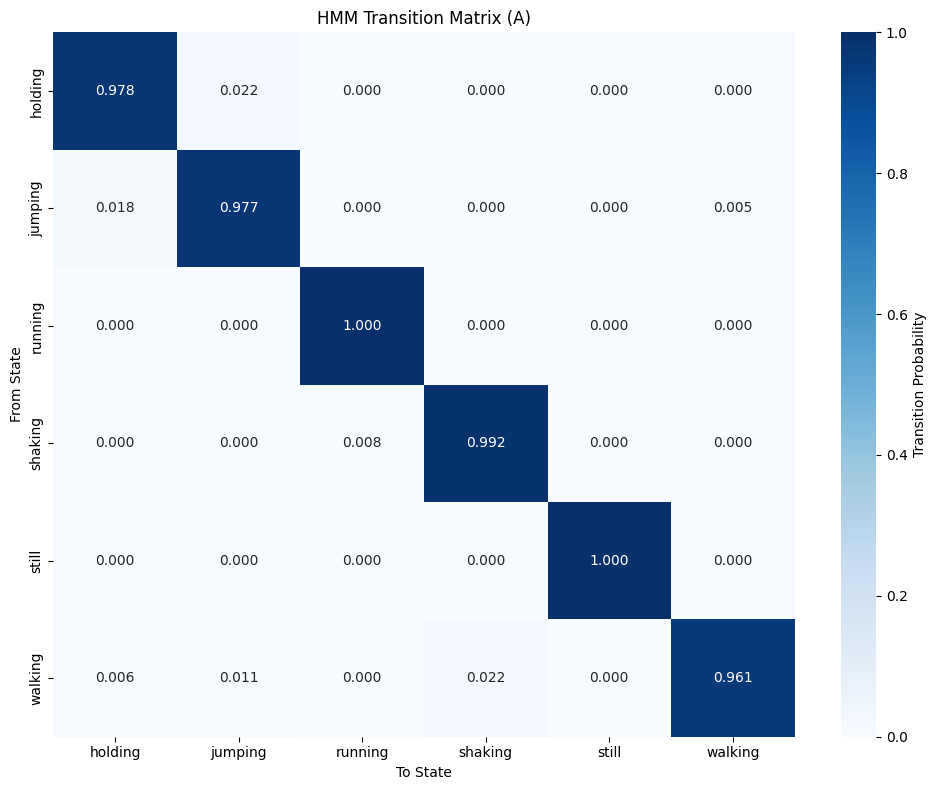

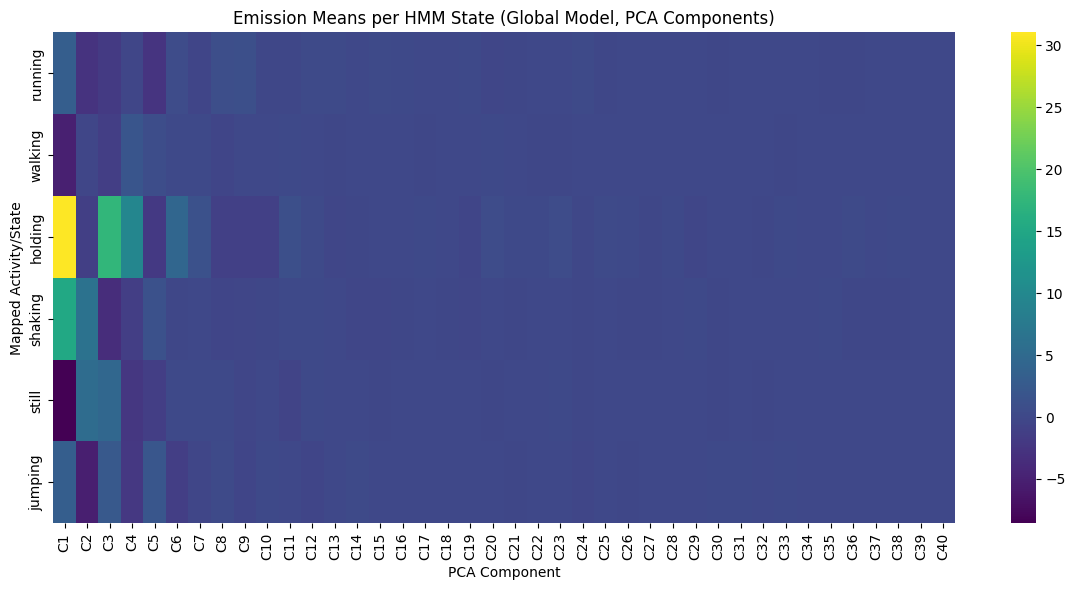

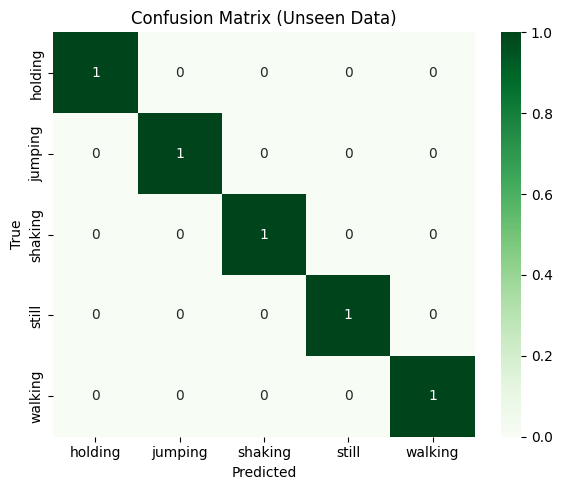

In [281]:
# Visualizations: Transition Matrix, Emission Means, and Confusion Matrix (Unseen Data)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# 1) Transition Probabilities (Global model)
plt.figure(figsize=(10, 8))
sns.heatmap(model.transmat_, annot=True, fmt='.3f', cmap='Blues',
            xticklabels=activity_labels, yticklabels=activity_labels,
            cbar_kws={'label': 'Transition Probability'})
plt.title('HMM Transition Matrix (A)')
plt.xlabel('To State')
plt.ylabel('From State')
plt.tight_layout()
plt.show()

# 2) Emission Means (in PCA feature space)
if hasattr(model, 'means_'):
    raw_means = model.means_
    # hmmlearn.GMMHMM means_ can be (n_components, n_mix, n_features)
    if raw_means.ndim == 3:
        weights = getattr(model, 'weights_', None)
        if weights is not None and np.isfinite(weights).all():
            means_2d = np.sum(weights[:, :, np.newaxis] * raw_means, axis=1)
        else:
            means_2d = np.mean(raw_means, axis=1)
    else:
        means_2d = raw_means
    
    # Build safe y-tick labels
    try:
        if 'state_to_activity_map' in globals() and isinstance(state_to_activity_map, dict):
            ytick = []
            for i in range(means_2d.shape[0]):
                mapped = state_to_activity_map.get(i, None)
                if mapped is not None and mapped < len(activity_labels):
                    ytick.append(activity_labels[mapped])
                else:
                    ytick.append(f"State {i}")
        else:
            ytick = [f"State {i}" for i in range(means_2d.shape[0])]
    except Exception:
        ytick = [f"State {i}" for i in range(means_2d.shape[0])]
    
    plt.figure(figsize=(12, 6))
    sns.heatmap(means_2d, cmap='viridis', cbar=True,
                xticklabels=[f'C{i+1}' for i in range(means_2d.shape[1])],
                yticklabels=ytick)
    plt.title('Emission Means per HMM State (Global Model, PCA Components)')
    plt.xlabel('PCA Component')
    plt.ylabel('Mapped Activity/State')
    plt.tight_layout()
    plt.show()
else:
    print('Model does not expose means_. Skipping emission means heatmap.')

# 3) Confusion Matrix from unseen test predictions
cm_source = (final_predictions if 'final_predictions' in globals() and len(final_predictions) > 0
             else [{'true_activity': p['true_activity'], 'predicted_activity': p['predicted_activity']} for p in predictions])
true_labels = [p['true_activity'] for p in cm_source]
pred_labels = [p['predicted_activity'] for p in cm_source]
labels_sorted = sorted(list(set(true_labels) | set(pred_labels)))
cm = confusion_matrix(true_labels, pred_labels, labels=labels_sorted)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=labels_sorted, yticklabels=labels_sorted)
plt.title('Confusion Matrix (Unseen Data)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()


## 14. Evaluation Results


In [282]:
# Calculate overall accuracy
correct = sum(1 for p in predictions if p['predicted_activity'] == p['true_activity'])
total = len(predictions)
accuracy = (correct / total * 100) if total > 0 else 0

print("\n" + "="*60)
print("EVALUATION RESULTS")
print("="*60)
print(f"\nOverall Accuracy: {accuracy:.1f}% ({correct}/{total})")

# Per-activity accuracy
print("\nPer-activity Performance:")
for true_activity in sorted(set(p['true_activity'] for p in predictions)):
    activity_preds = [p for p in predictions if p['true_activity'] == true_activity]
    activity_correct = sum(1 for p in activity_preds if p['predicted_activity'] == p['true_activity'])
    activity_accuracy = (activity_correct / len(activity_preds) * 100) if activity_preds else 0
    
    print(f"  {true_activity}: {activity_accuracy:.1f}% ({activity_correct}/{len(activity_preds)})")
    
    # Show predictions for this activity
    for pred in activity_preds:
        status = "✓" if pred['predicted_activity'] == pred['true_activity'] else "✗"
        print(f"    {pred['sequence_id']}: {pred['predicted_activity']} (confidence: {pred['confidence']:.1f}%) {status}")



EVALUATION RESULTS

Overall Accuracy: 100.0% (5/5)

Per-activity Performance:
  holding: 100.0% (1/1)
    holding_0: holding (confidence: 100.0%) ✓
  jumping: 100.0% (1/1)
    jumping_0: jumping (confidence: 100.0%) ✓
  shaking: 100.0% (1/1)
    shaking_0: shaking (confidence: 100.0%) ✓
  still: 100.0% (1/1)
    still_0: still (confidence: 100.0%) ✓
  walking: 100.0% (1/1)
    walking_0: walking (confidence: 100.0%) ✓


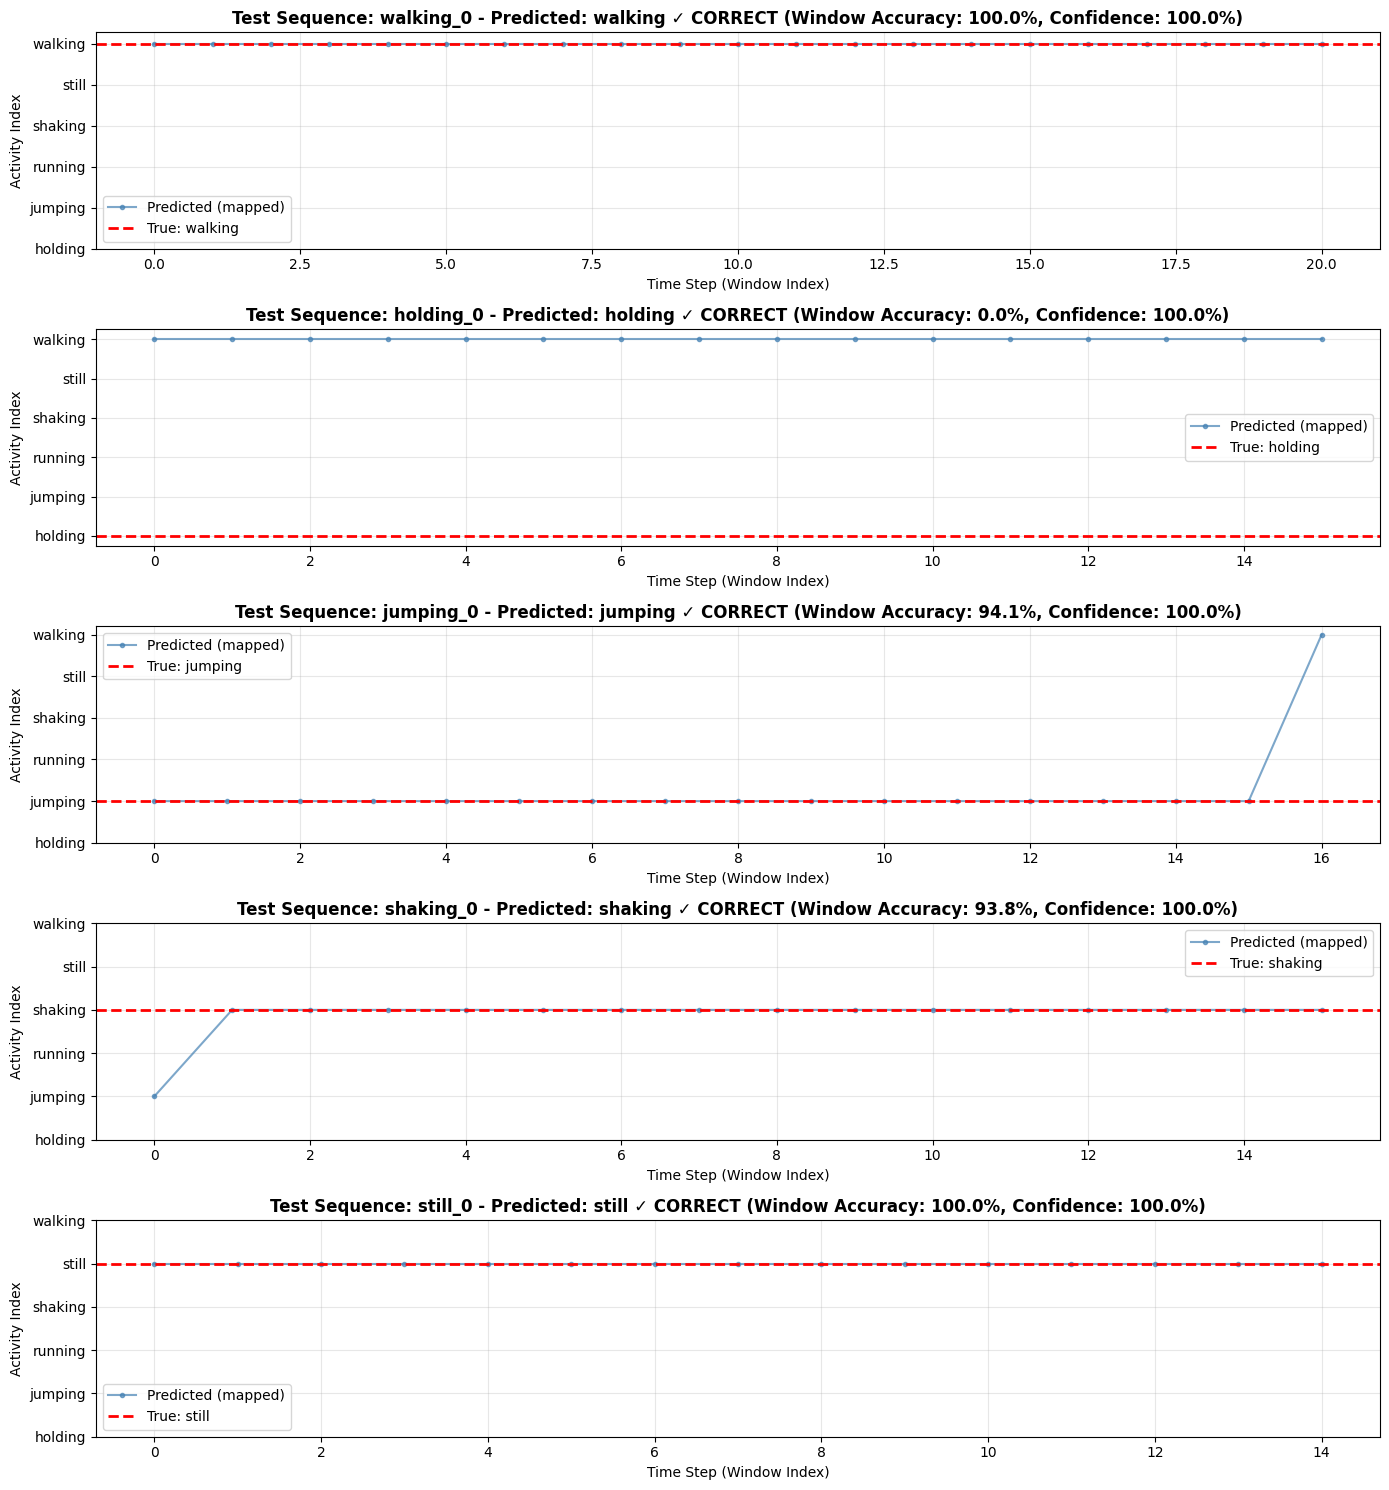

In [283]:
# Visualize predictions for unseen data
# Map raw HMM states to activity indices for interpretable visualization
fig, axes = plt.subplots(len(predictions), 1, figsize=(14, 3*len(predictions)))

if len(predictions) == 1:
    axes = [axes]

for idx, prediction in enumerate(predictions):
    ax = axes[idx]
    
    # Map predicted HMM states to activity indices using state_to_activity_map
    mapped_activity_indices = [state_to_activity_map[s] for s in prediction['predicted_states']]
    
    # Plot mapped activity indices over time
    time_steps = np.arange(len(mapped_activity_indices))
    ax.plot(time_steps, mapped_activity_indices, 'o-', 
           alpha=0.7, markersize=3, color='steelblue', label='Predicted (mapped)')
    
    # Find the index of true activity
    true_idx = activity_labels.index(prediction['true_activity']) if prediction['true_activity'] in activity_labels else 0
    
    # Use consistent color scheme: red for true activity (matches training plot)
    ax.axhline(y=true_idx, color='red', linestyle='--', 
               label=f'True: {prediction["true_activity"]}', linewidth=2)
    
    # Calculate sequence-level accuracy
    seq_accuracy = np.mean(np.array(mapped_activity_indices) == true_idx) * 100
    
    # Title
    status = "✓ CORRECT" if prediction['predicted_activity'] == prediction['true_activity'] else "✗ WRONG"
    ax.set_title(f'Test Sequence: {prediction["sequence_id"]} - Predicted: {prediction["predicted_activity"]} {status} '
                f'(Window Accuracy: {seq_accuracy:.1f}%, Confidence: {prediction["confidence"]:.1f}%)', 
                fontweight='bold')
    ax.set_xlabel('Time Step (Window Index)')
    ax.set_ylabel('Activity Index')
    ax.set_yticks(range(len(activity_labels)))
    ax.set_yticklabels(activity_labels)
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [284]:
# Save predictions
with open('results/unseen_predictions.pkl', 'wb') as f:
    pickle.dump(predictions, f)

print("\nPrediction results saved to results/unseen_predictions.pkl")
print("\n" + "="*60)
print("MODEL EVALUATION COMPLETE")
print("="*60)



Prediction results saved to results/unseen_predictions.pkl

MODEL EVALUATION COMPLETE


## 15. Calculate Sensitivity and Specificity


In [285]:
def calculate_sensitivity_specificity(predictions, activity_labels):
    """Calculate sensitivity and specificity for each activity."""
    results = {}
    
    for activity_idx, activity in enumerate(activity_labels):
        # True Positives: Correctly predicted as this activity
        tp = sum(1 for p in predictions 
                if p['true_activity'] == activity and p['predicted_activity'] == activity)
        
        # False Positives: Predicted as this activity but it's actually another
        fp = sum(1 for p in predictions 
                if p['predicted_activity'] == activity and p['true_activity'] != activity)
        
        # True Negatives: Correctly identified as NOT this activity
        tn = sum(1 for p in predictions 
                if p['true_activity'] != activity and p['predicted_activity'] != activity)
        
        # False Negatives: Actually this activity but predicted as another
        fn = sum(1 for p in predictions 
                if p['true_activity'] == activity and p['predicted_activity'] != activity)
        
        # Calculate metrics
        sensitivity = tp / (tp + fn) * 100 if (tp + fn) > 0 else 0
        specificity = tn / (tn + fp) * 100 if (tn + fp) > 0 else 0
        
        results[activity] = {
            'samples': tp + fn,  # total samples of this activity
            'tp': tp, 'fp': fp, 'tn': tn, 'fn': fn,
            'sensitivity': sensitivity,
            'specificity': specificity
        }
    
    return results

# Calculate metrics
metrics = calculate_sensitivity_specificity(predictions, activity_labels)

print("\n" + "="*80)
print("DETAILED EVALUATION METRICS")
print("="*80)

print("\n" + "-"*80)
print(f"{'Activity':<15} {'Samples':<10} {'Sensitivity':<15} {'Specificity':<15} {'Accuracy':<10}")
print("-"*80)

for activity in sorted(activity_labels):
    if activity in metrics:
        m = metrics[activity]
        acc = (m['tp'] + m['tn']) / (m['tp'] + m['tn'] + m['fp'] + m['fn']) * 100 if (m['tp'] + m['tn'] + m['fp'] + m['fn']) > 0 else 0
        print(f"{activity:<15} {m['samples']:<10} {m['sensitivity']:<15.1f}% {m['specificity']:<15.1f}% {acc:<10.1f}%")

# Overall accuracy
overall_acc = (sum(m['tp'] + m['tn'] for m in metrics.values()) / 
               sum(m['tp'] + m['tn'] + m['fp'] + m['fn'] for m in metrics.values()) * 100) if sum(m['tp'] + m['tn'] + m['fp'] + m['fn'] for m in metrics.values()) > 0 else 0
print("-"*80)
print(f"{'OVERALL':<15} {len(predictions):<10} {'-':<15} {'-':<15} {overall_acc:<10.1f}%")
print("="*80)



DETAILED EVALUATION METRICS

--------------------------------------------------------------------------------
Activity        Samples    Sensitivity     Specificity     Accuracy  
--------------------------------------------------------------------------------
holding         1          100.0          % 100.0          % 100.0     %
jumping         1          100.0          % 100.0          % 100.0     %
running         0          0.0            % 100.0          % 100.0     %
shaking         1          100.0          % 100.0          % 100.0     %
still           1          100.0          % 100.0          % 100.0     %
walking         1          100.0          % 100.0          % 100.0     %
--------------------------------------------------------------------------------
OVERALL         5          -               -               100.0     %


## 16. Final Summary


In [286]:
# Create evaluation summary table
print("\n" + "="*80)
print("EVALUATION SUMMARY TABLE")
print("="*80)
print("\nModel Evaluation on Unseen Data:")
print("\nState (Activity)    | Number of Samples | Sensitivity | Specificity | Overall Accuracy")
print("-"*80)

for activity in sorted(activity_labels):
    if activity in metrics:
        m = metrics[activity]
        acc = (m['tp'] + m['tn']) / (m['tp'] + m['tn'] + m['fp'] + m['fn']) * 100 if (m['tp'] + m['tn'] + m['fp'] + m['fn']) > 0 else 0
        print(f"{activity:<18} | {m['samples']:<16} | {m['sensitivity']:<11.1f}% | {m['specificity']:<11.1f}% | {acc:.1f}%")

print("-"*80)
print(f"{'TOTAL':<18} | {len(predictions):<16} | {'-':<11} | {'-':<11} | {overall_acc:.1f}%")
print("="*80)

# Save metrics
with open('results/evaluation_metrics.pkl', 'wb') as f:
    pickle.dump(metrics, f)

print("\n✅ All evaluation metrics saved to results/evaluation_metrics.pkl")
print("\n" + "="*80)
print("COMPLETE: Notebook execution finished successfully!")
print("="*80)



EVALUATION SUMMARY TABLE

Model Evaluation on Unseen Data:

State (Activity)    | Number of Samples | Sensitivity | Specificity | Overall Accuracy
--------------------------------------------------------------------------------
holding            | 1                | 100.0      % | 100.0      % | 100.0%
jumping            | 1                | 100.0      % | 100.0      % | 100.0%
running            | 0                | 0.0        % | 100.0      % | 100.0%
shaking            | 1                | 100.0      % | 100.0      % | 100.0%
still              | 1                | 100.0      % | 100.0      % | 100.0%
walking            | 1                | 100.0      % | 100.0      % | 100.0%
--------------------------------------------------------------------------------
TOTAL              | 5                | -           | -           | 100.0%

✅ All evaluation metrics saved to results/evaluation_metrics.pkl

COMPLETE: Notebook execution finished successfully!
